# Semester 1 Project Submission
- Adam Burstyn
- Nick/Julian

This notebook contains the code to explore the tables provided for the movie information

In [1]:
import pandas as pd
import sqlite3
import re
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline
#from get_total_movie_info import *
from helper_functions import *

## Explore links to combine tables

### Load tables from data scources

In [ ]:
# load tables from the sql db

# connect  to db
conn = sqlite3.connect("../Data/im.db")

# load movie basics table
movie_basics_df = pd.read_sql("SELECT * FROM movie_basics;", conn)

# load movie ratings table
movie_ratings_df = pd.read_sql("SELECT * FROM movie_ratings;", conn)

# load movie aka table
movie_akas_df = pd.read_sql("SELECT * FROM movie_akas;", conn)

### Load data from files

In [ ]:
# load movie gross data
movie_gross = pd.read_csv("../Data/bom.movie_gross.csv")

# load movie budget/gross data
movie_budgets = pd.read_csv("../Data/tn.movie_budgets.csv")

### Preview tables

In [ ]:
movie_budgets

In [ ]:
movie_gross

In [ ]:
movie_basics_df

In [ ]:
movie_ratings_df

* only about half of the movies have ratings, is it worth exploring an algorithm to impute the missing ratings?

In [ ]:
movie_akas_df

### Combine SQL tables

In [ ]:
# join tables on movie_id
df = movie_ratings_df.merge(movie_basics_df, how="inner", on="movie_id")
df = df.merge(movie_akas_df, how="inner", on="movie_id")
df

### Keep only US movies

In [ ]:
# find the tag for US region
df["region"].unique()

region is US as this is a US based company

In [ ]:
us_movies = df[df["region"]=="US"]
us_movies

In [ ]:
us_movies["movie_id"].nunique()

There are duplicate movie ids

In [ ]:
# keep only 1 entry for each movie id
us_movies = us_movies.drop_duplicates(subset=["movie_id"])
us_movies

### Add in gross numbers

#### Clean movie title and year info for merging
- use primary title as title
- all lowercase
- keep only alpha-numeric values
- remove spaces
    - to eliminate issues with titles contaning "Star Wars:Episode 3" vs "Star Wars: Episode 3"

** We will merge on title and year to differentiate between movies with the same title relseased in different year (remakes)

In [ ]:
# use RegEx to keep only alpha-numeric values, remove spaces and make all letters lowercase 
#us_movies["title"] = us_movies["title"].map(lambda x: re.sub(r'[^A-Za-z0-9 ]+', '', x).lower())
us_movies["title"] = us_movies["primary_title"]

us_movies["title"] = us_movies["title"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())
movie_budgets["movie"] = movie_budgets["movie"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())
movie_gross["title"] = movie_gross["title"].map(lambda x: re.sub(r'[^A-Za-z0-9]+', '', x).lower())

In [ ]:
# get a year column as int to match other df data types
movie_budgets["year"] = movie_budgets["release_date"].map(lambda x: int(x[-4:]))
movie_budgets.head()

In [ ]:
# rename columns to match for merging
movie_budgets.rename(columns={"movie": "title", "domestic_gross": "domestic_gross_movie_budgets",
                              "worldwide_gross": "worldwide_gross_movie_budgets"}, inplace=True)

movie_gross.rename(columns={"domestic_gross": "domestic_gross_movie_gross", 
                            "foreign_gross": "foreign_gross_movie_gross"}, inplace=True)

us_movies.rename(columns={"start_year": "year"}, inplace=True)

#### Merge dataframes to get all gross revenue info

In [ ]:
final_gross_df1 = us_movies.merge(movie_budgets, on=["title", "year"], how="inner")#.drop_duplicates(subset=["movie_id"])
len(final_gross_df1), final_gross_df1["movie_id"].nunique()

In [ ]:
final_gross_df1.head()

In [ ]:
final_gross_df2 = us_movies.merge(movie_gross, on=["title", "year"], how="inner")#.drop_duplicates(subset=["movie_id"])
len(final_gross_df2), final_gross_df2["movie_id"].nunique()

In [ ]:
final_gross_df2.head()

In [ ]:
# concatenate the dataframes to contain records from both gross and budget dataframes
final_gross_all = pd.concat([final_gross_df1, final_gross_df2]).drop_duplicates(subset=["movie_id"])
len(final_gross_all), final_gross_all["movie_id"].nunique()

In [ ]:
final_gross_all.head()

## View Data Visualizations

In [2]:
# get cleaned df the from helper function
total_movie_info = get_clean_df().drop_duplicates(subset=["movie_id"]).dropna(subset=["clean_domestic_gross", "clean_worldwide_gross"])
total_movie_info

,movie_id,averagerating,numvotes,primary_title,original_title,year,runtime_minutes,genres,ordering,title,...,id,release_date,production_budget,domestic_gross_movie_budgets,worldwide_gross_movie_budgets,studio,domestic_gross_movie_gross,foreign_gross_movie_gross,clean_domestic_gross,clean_worldwide_gross
0,tt1043726,4.2,50352,The Legend of Hercules,The Legend of Hercules,2014,99.0,"Action,Adventure,Fantasy",20,thelegendofhercules,...,42.0,"Jan 10, 2014",70000000.0,18848538.0,58953319.0,NaN,NaN,NaN,18848538.0,58953319.0
1,tt1171222,5.1,8296,Baggage Claim,Baggage Claim,2013,96.0,Comedy,5,baggageclaim,...,38.0,"Sep 27, 2013",8500000.0,21569509.0,22885836.0,NaN,NaN,NaN,21569509.0,22885836.0
2,tt1210166,7.6,326657,Moneyball,Moneyball,2011,133.0,"Biography,Drama,Sport",14,moneyball,...,15.0,"Sep 23, 2011",50000000.0,75605492.0,111300835.0,NaN,NaN,NaN,75605492.0,111300835.0
3,tt1212419,6.5,87288,Hereafter,Hereafter,2010,129.0,"Drama,Fantasy,Romance",4,hereafter,...,61.0,"Oct 15, 2010",50000000.0,32746941.0,108660270.0,NaN,NaN,NaN,32746941.0,108660270.0
4,tt1232829,7.2,477771,21 Jump Street,21 Jump Street,2012,109.0,"Action,Comedy,Crime",26,21jumpstreet,...,44.0,"Mar 16, 2012",42000000.0,138447667.0,202812429.0,NaN,NaN,NaN,138447667.0,202812429.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1050,tt0975645,6.8,68315,Hitchcock,Hitchcock,2012,98.0,"Biography,Comedy,Drama",12,hitchcock,...,NaN,NaN,NaN,NaN,NaN,FoxS,6000000.0,17600000.0,6000000.0,6000000.0
1054,tt2055765,5.8,11145,The English Teacher,The English Teacher,2013,93.0,"Comedy,Drama",19,theenglishteacher,...,NaN,NaN,NaN,NaN,NaN,Cdgm.,105000.0,NaN,105000.0,105000.0
1056,tt2132285,5.6,77726,The Bling Ring,The Bling Ring,2013,90.0,"Biography,Crime,Drama",1,theblingring,...,NaN,NaN,NaN,NaN,NaN,A24,5800000.0,13300000.0,5800000.0,5800000.0
1059,tt2463288,6.0,48134,Walk of Shame,Walk of Shame,2014,95.0,Comedy,12,walkofshame,...,NaN,NaN,NaN,NaN,NaN,FCW,59200.0,NaN,59200.0,59200.0


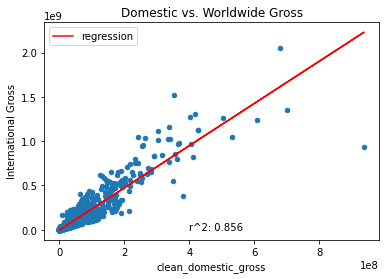

In [3]:
# investigate if there is there a relationship between domestic gross and foreign gross
ax = total_movie_info.plot(x="clean_domestic_gross", y="clean_worldwide_gross", kind="scatter",
                           title="Domestic vs. Worldwide Gross", xlabel="Domestic Gross", ylabel="International Gross")

# plot regression line
m = stats.linregress(total_movie_info["clean_domestic_gross"].to_list(), y=total_movie_info["clean_worldwide_gross"].to_list())
t = [m.slope * i + m.intercept for i in total_movie_info["clean_domestic_gross"]]

total_movie_info["regression"] = t

total_movie_info.plot.line(x="clean_domestic_gross", y="regression", color='r', ax=ax)
ax.annotate(f"r^2: {round(m.rvalue**2, 3)}", xy=(400000000, 1));

There is a very high correlation between domestic and international gross. Either variable will be sufficeint to use as a metric.

In [ ]:
# find mean top revenue producing genres
counts = total_movie_info.groupby("genres").count()[["movie_id"]]
means = total_movie_info.groupby("genres").mean()[["clean_domestic_gross", "clean_worldwide_gross", "production_budget"]].head(50).sort_values("clean_domestic_gross", ascending=False)
top_genres = means.merge(counts, how="inner", on="genres").rename(columns={"movie_id": "num_movies"})

top_genres[["clean_domestic_gross"]].head(10).plot.bar(title="Top 10 Mean Grossing Genres",
                                                       ylabel="Mean Gross", xlabel="Genre", legend=False);

The "Action, Adventure, Sci-Fi" and "Action, Adventure, Animation" genres have the highest grossing means. Are they statistically higher than the other categories?

In [ ]:
# view the distribution of the top genre
aascfi_df = total_movie_info[total_movie_info["genres"]=="Action,Adventure,Sci-Fi"]

#sns.distplot(aascfi_df["clean_domestic_gross"]);
sns.histplot(aascfi_df["clean_domestic_gross"]);

This distribution is right skewed. The lower end of the range may be more appropriate to investiage since it is skewed.

In [ ]:
# further investigate lower end subset
aascfi_subset = aascfi_df[aascfi_df["clean_domestic_gross"]<=100000000]

sns.histplot(aascfi_subset["clean_domestic_gross"]);

This subset has a better distribution, but it is very limited in number of data points.

## Investigate merging Rotten Tomatoes Data

### Load data

In [ ]:
# load RT data
rt_movie_info = pd.read_table("../Data/rt.movie_info.tsv")
rt_reviews = pd.read_table("../Data/rt.reviews.tsv", encoding = 'latin-1')

In [ ]:
rt_movie_info.head()

In [ ]:
rt_reviews.head()

*There are multiple ratings for each movie, they will need to be averaged out if used

We will attempt to merge RT data with the other tables based on director and release date (highly unlikely that a producer released multiple movies on the same date)